<a href="https://colab.research.google.com/github/ClaireJ59/ClaireJ59.github.io/blob/main/BackGround_Remove.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#蝴蝶蘭去背程式

---



###Step1: 安裝套件

In [2]:

!pip install rembg onnxruntime pillow --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 90.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.0 MB/s eta 0:00:00


###Step2: 去背圖片(簡單-fast)

Saving [L]1743246937498.jpg to [L]1743246937498 (3).jpg



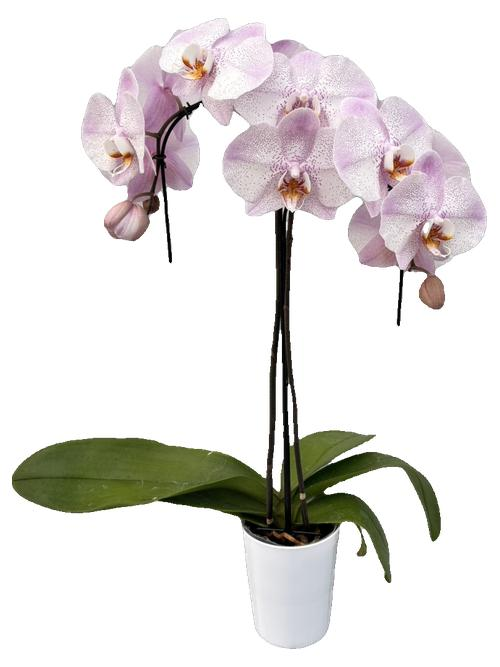

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [6]:
import os
from PIL import Image
from rembg import remove, new_session
from google.colab import files
from IPython.display import display, HTML
import io
import zipfile
import base64 # 匯入 base64 模組

# 建立輸出資料夾
os.makedirs("outputs", exist_ok=True)

# 工具函數：顯示提示訊息
def show_message(msg):
    display(HTML(f"<div style='font-size:16px; color:#333; margin:10px 0;'>{msg}</div>"))

# 工具函數：清理 alpha 邊緣
def clean_alpha(img, threshold=200):
    r, g, b, a = img.split()
    a = a.point(lambda p: 255 if p >= threshold else 0)
    return Image.merge("RGBA", (r, g, b, a))

# 工具函數：混白底避免黑邊
def remove_alpha_halo(img, bg_color=(255, 255, 255)):
    bg = Image.new("RGBA", img.size, bg_color + (255,))
    return Image.alpha_composite(bg, img).convert("RGB")

# 工具函數：根據檔名開頭取得縮放比例
def get_scale_ratio(filename):
    if filename.startswith("[L]"):
        return 0.95
    elif filename.startswith("[M]"):
        return 0.85
    elif filename.startswith("[S]"):
        return 0.75
    else:
        return 0.85  # 預設比例

# 單張圖片處理函數
def process_image(file_name, session):
    base_name = os.path.splitext(os.path.basename(file_name))[0]
    show_message(f"🔧 處理圖片中：<b>{base_name}</b>")
    ratio = get_scale_ratio(base_name)

    # 去背
    original = Image.open(file_name).convert("RGBA")
    with io.BytesIO() as buf:
        original.save(buf, format="PNG")
        removed_bytes = remove(buf.getvalue(), session=session)
    removed_img = Image.open(io.BytesIO(removed_bytes)).convert("RGBA")

    # 清除殘影與裁切主體
    removed_img = clean_alpha(removed_img)
    alpha = removed_img.split()[3]
    bbox = alpha.getbbox()
    cropped = removed_img.crop(bbox)

    # 縮放並置中至白底畫布
    canvas_size = (500, 667)
    target_width = int(canvas_size[0] * ratio)
    target_height = int(canvas_size[1] * ratio)
    cropped.thumbnail((target_width, target_height), Image.LANCZOS)
    flattened = remove_alpha_halo(cropped)

    background = Image.new("RGB", canvas_size, (255, 255, 255))
    x = (canvas_size[0] - flattened.size[0]) // 2
    y = (canvas_size[1] - flattened.size[1]) // 2
    background.paste(flattened, (x, y))

    # 儲存與顯示
    output_path = f"outputs/{base_name}.jpg"
    background.save(output_path, "JPEG", quality=95)

    show_message(f"✅ 完成：<b>{base_name}</b> 處理後圖片如下：")

    # 將圖片轉換為 Base64 編碼，以便在 HTML 中顯示
    buffered = io.BytesIO()
    background.save(buffered, format="JPEG")
    # ****** 關鍵修改在這行 ******
    img_str = base64.b64encode(buffered.getvalue()).decode()
    # 這裡調整顯示圖片的大小，例如最大高度設為 200px
    display(HTML(f'<img src="data:image/jpeg;base64,{img_str}" style="max-height: 200px;">'))


    return output_path

# 步驟 1：上傳圖片
show_message("📤 請上傳要處理的圖片（可多選）：")
uploaded = files.upload()

# 步驟 2：初始化去背模型
show_message("📦 第一次執行時，系統會自動下載 U²-Net 去背模型，請稍候約 10–30 秒...")
session = new_session("u2net")
show_message("🚀 模型載入完成，開始進行圖片處理...")

# 處理圖片
all_outputs = []
for file_name in uploaded.keys():
    final_path = process_image(file_name, session)
    all_outputs.append(final_path)

# 打包下載
zip_name = "outputs.zip"
with zipfile.ZipFile(zip_name, "w") as zipf:
    for file in all_outputs:
        zipf.write(file)

show_message("📥 所有圖片已處理並打包完成，正在下載壓縮檔：")
files.download(zip_name)

###Step2.5 (複雜-slow)
#####如果上面的結果不滿意可以試試這個模型

Saving [S]1213692.jpg to [S]1213692 (2).jpg
Saving [L]1743246937498.jpg to [L]1743246937498 (4).jpg
Saving [S]1743259777350.jpg to [S]1743259777350 (2).jpg
Saving [L]1743246937354.jpg to [L]1743246937354 (2).jpg
Saving [M]1743246871656.jpg to [M]1743246871656 (2).jpg
Saving [M]1743246937234.jpg to [M]1743246937234 (2).jpg
Saving [M]1743246899912.jpg to [M]1743246899912 (2).jpg


100%|████████████████████████████████████████| 179M/179M [00:00<00:00, 160GB/s]



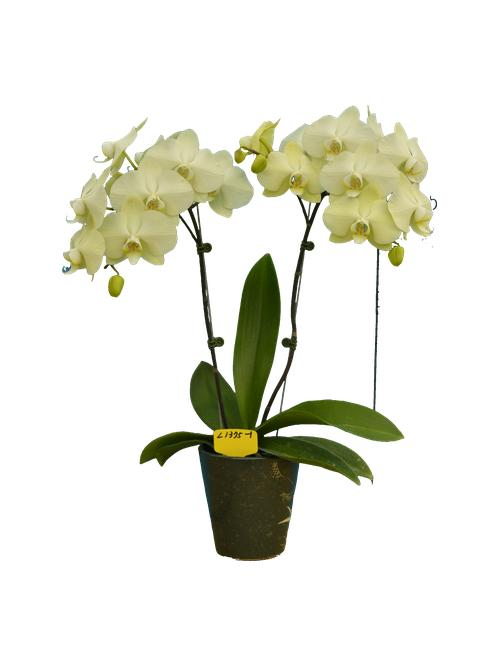


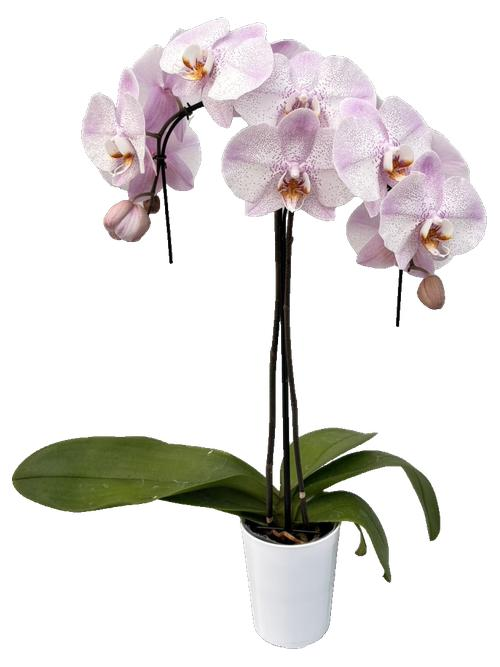


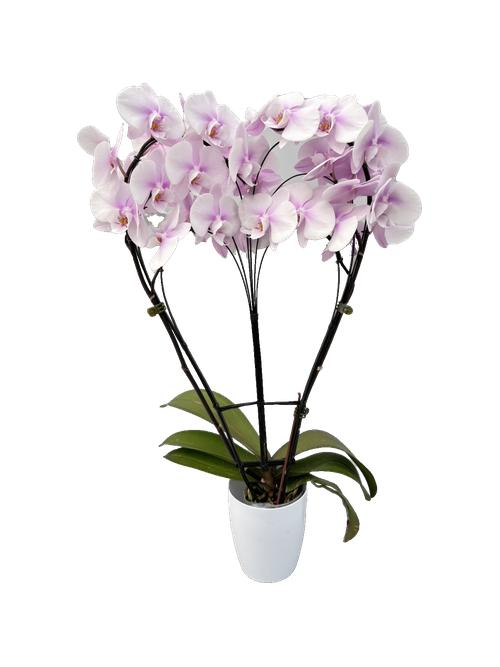


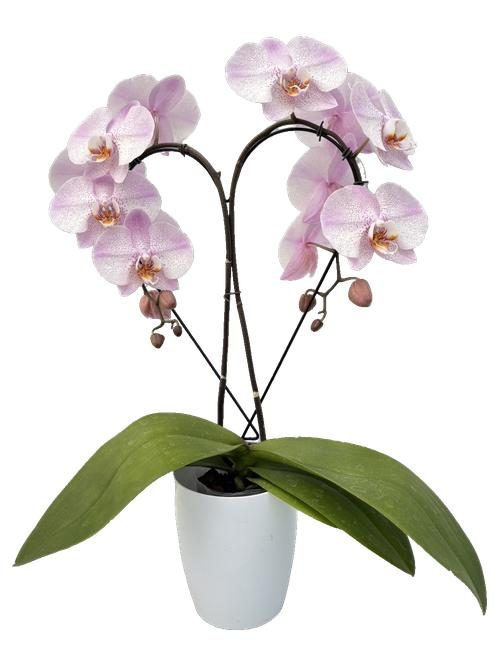


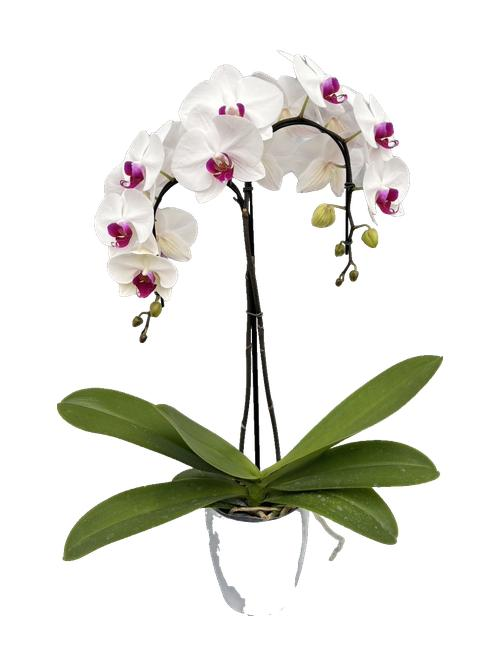


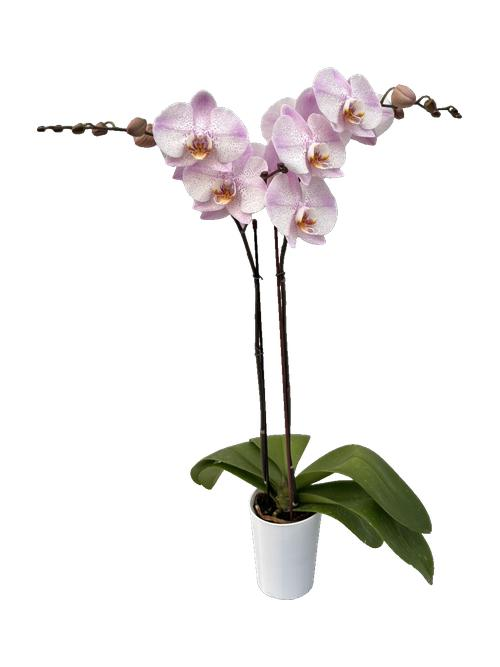


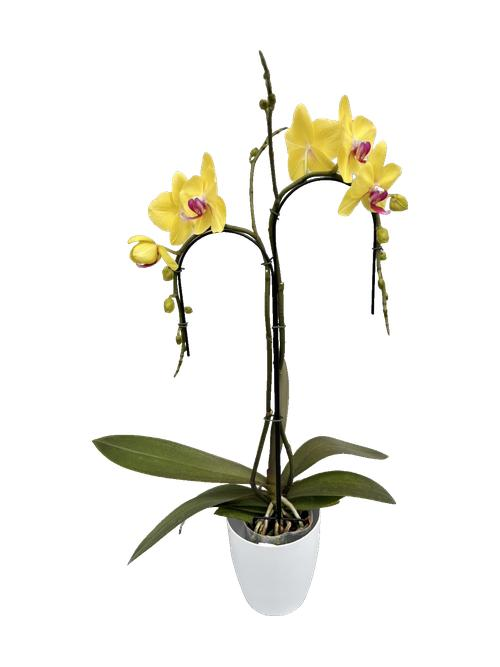

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [7]:
import os
from PIL import Image
from rembg import remove, new_session
from google.colab import files
from IPython.display import display, HTML # 匯入顯示相關模組
import io
import zipfile
import base64 # 匯入 base64 模組，用於圖片顯示

# 建立輸出資料夾
os.makedirs("outputs", exist_ok=True)

# --- 工具函數區 ---

# 工具函數：顯示提示訊息 (用 HTML 格式化文字)
def show_message(msg):
    display(HTML(f"<div style='font-size:16px; color:#333; margin:10px 0;'>{msg}</div>"))

# 工具函數：清理 alpha 邊緣 (將半透明像素轉為全透明或不透明，避免殘影)
def clean_alpha(img, threshold=180):
    r, g, b, a = img.split() # 分離 R, G, B, Alpha 四個通道
    # 對 Alpha 通道進行處理：像素值大於等於 threshold 的設為 255 (完全不透明)，否則設為 0 (完全透明)
    a = a.point(lambda p: 255 if p >= threshold else 0)
    return Image.merge("RGBA", (r, g, b, a)) # 合併回 RGBA 圖片

# 工具函數：混白底避免黑邊 (將去背後的圖片疊加到白色背景上，消除邊緣可能出現的黑邊)
def remove_alpha_halo(img, bg_color=(255, 255, 255)):
    # 建立一個與原圖大小相同的純色 (預設白色) 背景圖，並設為 RGBA 模式 (Alpha 值 255 表示完全不透明)
    bg = Image.new("RGBA", img.size, bg_color + (255,))
    # 將去背圖疊加到背景圖上，並轉換為 RGB 模式 (丟棄 Alpha 通道)
    return Image.alpha_composite(bg, img).convert("RGB")

# 工具函數：根據檔名開頭取得縮放比例
def get_scale_ratio(filename):
    if filename.startswith("[L]"): # 如果檔名以 "[L]" 開頭，使用 95% 比例
        return 0.95
    elif filename.startswith("[M]"): # 如果檔名以 "[M]" 開頭，使用 85% 比例
        return 0.85
    elif filename.startswith("[S]"): # 如果檔名以 "[S]" 開頭，使用 75% 比例
        return 0.75
    else:
        return 0.85  # 如果沒有特殊標記，預設使用 85% 比例

# --- 核心處理函數 ---

# 單張圖片處理函數
def process_image(file_name, session):
    # 從完整檔名中提取不含副檔名的基礎檔名
    base_name = os.path.splitext(os.path.basename(file_name))[0]
    show_message(f"🔧 處理圖片中：<b>{base_name}</b>") # 顯示正在處理的圖片名稱
    ratio = get_scale_ratio(base_name) # 根據檔名獲取縮放比例

    # 開啟圖片並去背
    original = Image.open(file_name).convert("RGBA") # 以 RGBA 模式開啟原始圖片
    with io.BytesIO() as buf: # 建立記憶體緩衝區
        original.save(buf, format="PNG") # 將圖片存入緩衝區 (PNG 格式保留 Alpha)
        # 使用 rembg 進行去背，並將結果存為 bytes
        removed_bytes = remove(buf.getvalue(), session=session)
    # 從去背後的 bytes 數據重新載入為 PIL Image 對象，並轉換為 RGBA
    removed_img = Image.open(io.BytesIO(removed_bytes)).convert("RGBA")

    # 清除殘影 (將半透明邊緣處理為透明或不透明)
    removed_img = clean_alpha(removed_img, threshold=180)

    # 主體裁切 (根據 Alpha 通道找到主體的最小邊界框並裁切)
    alpha = removed_img.split()[3] # 取得 Alpha 通道
    bbox = alpha.getbbox() # 獲取非透明區域的邊界框 (left, upper, right, lower)
    cropped = removed_img.crop(bbox) # 根據邊界框裁切圖片

    # 計算縮放目標尺寸 (基於預設畫布尺寸和縮放比例)
    canvas_size = (500, 667) # 最終輸出圖片的畫布尺寸 (寬, 高)
    target_width = int(canvas_size[0] * ratio) # 計算目標寬度
    target_height = int(canvas_size[1] * ratio) # 計算目標高度
    # 等比例縮放圖片至目標尺寸 (使用 LANCZOS 高品質濾鏡)
    cropped.thumbnail((target_width, target_height), Image.LANCZOS)

    # 混白底避免黑邊 (將裁切並縮放後的主體疊加到白色背景上)
    flattened = remove_alpha_halo(cropped)

    # 建立白底畫布並置中貼上處理後的主體
    background = Image.new("RGB", canvas_size, (255, 255, 255)) # 建立一個新的白色 RGB 畫布
    # 計算置中位置
    x = (canvas_size[0] - flattened.size[0]) // 2
    y = (canvas_size[1] - flattened.size[1]) // 2
    background.paste(flattened, (x, y)) # 將處理後的主體貼到畫布上

    # 儲存處理後的圖片 (JPEG 格式，品質 95)
    output_path = f"outputs/{base_name}.jpg"
    background.save(output_path, "JPEG", quality=95)

    show_message(f"✅ 完成：<b>{base_name}</b> 處理後圖片如下：")

    # 將圖片轉換為 Base64 編碼，以便在 HTML 中顯示
    buffered = io.BytesIO() # 建立記憶體緩衝區
    background.save(buffered, format="JPEG") # 將圖片存入緩衝區
    # 將緩衝區內容 Base64 編碼，並解碼為 UTF-8 字串
    img_str = base64.b64encode(buffered.getvalue()).decode('utf-8')
    # 使用 HTML 的 <img> 標籤顯示圖片，並限制最大高度為 200px
    display(HTML(f'<img src="data:image/jpeg;base64,{img_str}" style="max-height: 200px;">'))

    return output_path

# --- 主程式流程 ---

# 步驟 1：上傳圖片
show_message("📤 請上傳要處理的圖片（可多選）：")
uploaded = files.upload() # 呼叫 Colab 檔案上傳介面

# 步驟 2：初始化去背模型
show_message("📦 第一次執行時，系統會自動下載 **isnet-general-use** 去背模型，請稍候。")
# 載入指定的去背模型，"isnet-general-use" 是一個通用且較精確的模型
session = new_session("isnet-general-use")
show_message("🚀 模型載入完成，開始進行圖片處理...")

# 處理所有上傳的圖片
all_outputs = [] # 用於儲存所有輸出檔案的路徑
for file_name in uploaded.keys(): # 遍歷所有上傳的檔案
    final_path = process_image(file_name, session) # 處理單張圖片
    all_outputs.append(final_path) # 將處理結果路徑加入列表

# 打包下載所有處理後的圖片為 ZIP 壓縮檔
zip_name = "outputs.zip"
with zipfile.ZipFile(zip_name, "w") as zipf:
    for file in all_outputs:
        zipf.write(file) # 將每個處理後的圖片檔案寫入 ZIP

show_message("📥 所有圖片已處理並打包完成，正在下載壓縮檔：")
files.download(zip_name) # 提供壓縮檔下載連結